In [1]:
from shared.preface import *
import shared.functions as fct

## Ch. 0: Preliminary Investigations.

### 2D grid, center coord. pairs.

In [2]:
def grid_2D(l, s):

    # 2D spatial grid, discretized.
    eps = s/10
    x, y = np.mgrid[-l:l+eps:s, -l:l+eps:s]

    # [x y] edge coordinate pairs of above grid.
    xy = np.mgrid[-l:l+eps:s, -l:l+eps:s].reshape(2,-1).T

    # Create center coord.-pairs.
    x_centers = (x[1:,:] + x[:-1,:])/2.
    y_centers = (y[:,1:] + y[:,:-1])/2.
    centers = np.array([x_centers[:,:-1], y_centers[:-1,:]])
    cent_coordPairs2D = centers.reshape(2,-1).T
    print('All coord. pairs 2D:\n', cent_coordPairs2D)
    # print('Coord pairs 2D shape:', cent_coordPairs2D.shape)

    return cent_coordPairs2D

limit_coarse, space_coarse = 1.5, 1.
cent_coordPairs2D = grid_2D(limit_coarse, space_coarse)

# Delete middle square.
cent_coordPairs2D = np.delete(cent_coordPairs2D, 4, axis=0)

# Create finegrained square.
limit_fine, space_fine = limit_coarse/2., space_coarse/2.
cent_coordPairs2D_fine = grid_2D(limit_fine, space_fine)

# Insert finegrained square.

All coord. pairs 2D:
 [[-1. -1.]
 [-1.  0.]
 [-1.  1.]
 [ 0. -1.]
 [ 0.  0.]
 [ 0.  1.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]]
All coord. pairs 2D:
 [[-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.   0.5]
 [ 0.5 -0.5]
 [ 0.5  0. ]
 [ 0.5  0.5]]


### 3D grid, center coord. pairs.

In [3]:
# 3D spatial grid, discretized.
x, y, z = np.mgrid[-1:1.1:1., -1:1.1:1., -1:1.1:1.]
# print(x[0,...], x.shape)

x_centers = (x[1:,...] + x[:-1,...])/2.
# print(x_centers, x_centers.shape)

y_centers = (y[:,1:,:] + y[:,:-1,:])/2.
# print(y_centers, y_centers.shape)

z_centers = (z[...,1:] + z[...,:-1])/2.
# print(z_centers, z_centers.shape)


# Create center coord.-pairs., truncate redundant points.
centers3D = np.array([
    x_centers[:,:-1,:-1], 
    y_centers[:-1,:,:-1], 
    z_centers[:-1,:-1,:]
])
# print(centers3D, centers3D.shape)

cent_coordPairs3D = centers3D.reshape(3,-1).T 
print(cent_coordPairs3D, cent_coordPairs3D.shape)

[[-0.5 -0.5 -0.5]
 [-0.5 -0.5  0.5]
 [-0.5  0.5 -0.5]
 [-0.5  0.5  0.5]
 [ 0.5 -0.5 -0.5]
 [ 0.5 -0.5  0.5]
 [ 0.5  0.5 -0.5]
 [ 0.5  0.5  0.5]] (8, 3)


## Ch. 1: Milky Way-type halo and simple grid.

### 3D plot of the DM particles.

126187


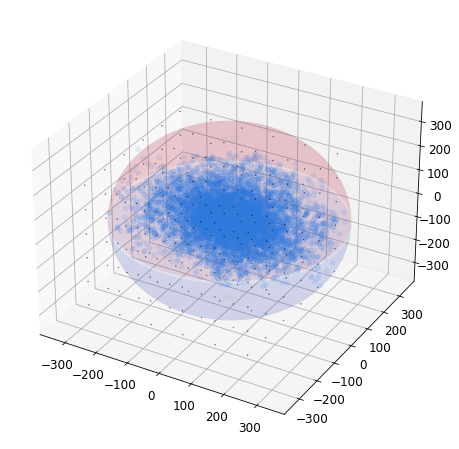

In [12]:
# Read DM particles.
fct.read_DM_positions_randomHalo(which_halos='halos', mass_select=12)

# Build grid around Milky Way.
MW_grid = fct.grid_3D(GRID_L, GRID_S) / kpc

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Read in DM particle positions.
DM_pos = np.load('sim_data/DM_positions_halos_M12.npy')
print(f'{len(DM_pos)}')
x_DM, y_DM, z_DM = DM_pos[:,0], DM_pos[:,1], DM_pos[:,2]
cut = 10
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]

ax.scatter(x, y, z, alpha=0.1, c='dodgerblue')

# Draw sphere around GC with radius=Rvir_MW.
rGC = Rvir_MW/kpc
uGC, vGC = np.mgrid[0:2 * np.pi:200j, 0:np.pi:100j]
xGC = rGC * np.cos(uGC) * np.sin(vGC)
yGC = rGC * np.sin(uGC) * np.sin(vGC)
zGC = rGC * np.cos(vGC)

xg, yg, zg = MW_grid[:,0], MW_grid[:,1], MW_grid[:,2] 
ax.scatter(xg, yg, zg, s=0.2, marker='x', color='black', alpha=0.5)


ax.plot_surface(
    xGC, yGC, zGC, alpha=0.1, 
    cmap=plt.cm.coolwarm, vmin=-1, vmax=1,# antialiased=False,
    rstride=1, cstride=1
)

plt.show()

### Calculate gravity in each cell.

In [5]:
DM_pos = np.load('sim_data/DM_positions_halos_M12.npy')

### Testing 1 cell with coords. at earth.
cell_id = 0
cell1 = np.array([8.5, 0, 0])*kpc

cell_vector = fct.cell_gravity(cell1, DM_pos, GRAV_RANGE, DM_SIM_MASS)
cell_vector /= (kpc/s**2)  
print(cell_vector)
print(np.sqrt(np.sum(cell_vector**2)))

#! this should be around same order of magnitude as in spher. symmetric setup.

[-1.47629727e-29 -1.71292523e-32  4.08050370e-31]
1.4768620802502691e-29


## Ch. 2: Broadcasting for cell_gravity.

In [6]:
fct.read_DM_positions_randomHalo(which_halos='halos', mass_select=12)
DM = np.load('sim_data/DM_positions_halos_M12.npy')[1::10]
grid = fct.grid_3D(GRID_L, GRID_S)

grid = np.expand_dims(grid, axis=1)

DM = np.expand_dims(DM, axis=0)
DM = np.repeat(DM, len(grid), axis=0)

# diff = DM - grid
# print(diff.shape, (diff.nbytes)/1e6)

fct.cell_gravity_3D(grid, DM, GRAV_RANGE, DM_SIM_MASS)
dPsi_grid = np.load('CubeSpace/dPsi_grid_snapsnot_X.npy')
dPsi_grid /= (kpc/s**2) 
mags = np.sqrt(np.sum(dPsi_grid**2, axis=1))
print(mags[0])

5.3898472398479194e-33


## Ch. 3: Combined precalculations for all snapshots.

In [7]:
from shared.preface import *
import shared.functions as fct

for i in range(12,37):
    snap_i = f'{i:04d}'
    print(snap_i)

    # 1. Read in DM positions of halo in snapshot.
    fct.read_DM_positions_randomHalo(
        which_halos='halos', mass_select=12, mass_range=1., snap_num=snap_i
        )
    DM_pos = np.load('sim_data/DM_positions_halos_M12.npy')[1::10]

    # 2. Build the spatial grid, depending on virial radius of halo, etc.
    cell_grid = fct.grid_3D(GRID_L, GRID_S)
    np.save(f'CubeSpace/cell_grid_snapsnot_{snap_i}', cell_grid)
    cell_grid = np.expand_dims(cell_grid, axis=1)

    # 2.5 Adjust arrays.
    DM_pos = np.expand_dims(DM_pos, axis=0)
    DM_pos = np.repeat(DM_pos, len(cell_grid), axis=0)

    # 3. Calculate derivatives of each cell.
    fct.cell_gravity_3D(
        cell_grid, DM_pos, GRAV_RANGE, DM_SIM_MASS, snap_num=snap_i
        )

0012
0013
0014
0015
0016
0017
0018
0019
0020
0021
0022
0023
0024
0025
0026
0027
0028
0029
0030
0031
0032
0033
0034
0035
0036


snapshot_0012 is at redshift ~3.8.

**BUT** it contains no halo of mass_select=12 anymore.

**TODO:** start at snapshot_0036 (z~1e-16) and **trace same halo** backwards through the
snapshots.

Ugly fix for now: Extended mass_select window to search down to 1e11*Msun halos.
Then just pick random halo, will not be the same in all snapshots.

### Redshift z of each snapshot.

In [8]:
zeds = np.zeros(25)
nums = []
for j, i in enumerate(range(12,37)):
    snap_i = f'{i:04d}'
    nums.append(snap_i)

    with h5py.File(f'{SIM_DATA}/snapshot_{snap_i}.hdf5') as snap:
        zeds[j] = snap['Cosmology'].attrs['Redshift'][0]

np.save(f'shared/ZEDS_SNAPSHOTS.npy', np.asarray(zeds))
np.save(f'shared/NUMS_SNAPSHOTS.npy', np.asarray(nums))

## Ch. 4: Better derivative grid structure. 

In [ ]:
# Function for grouping DM particles around cells.
# Framed differently: how much DM particles are around each cell?

def DMnum_around_cell(cell_length):
    """Amount of DM particles in sphere around cell."""

    # Center all DM positions w.r.t. cell center.
    DM_cc = DM_coords*kpc - cell_coords

    # Calculate distances of DM to cc.
    DM_dist = np.sqrt(np.sum(DM_cc**2, axis=2))

    # Ascending order indices.
    ind = DM_dist.argsort(axis=1)
    ind_3D = np.expand_dims(ind, axis=2)
    ind_3D = np.repeat(ind_3D, 3, axis=2)

    # Sort DM positions according to dist.
    DM_pos_sort = np.take_along_axis(DM_cc, ind_3D, axis=1)
    DM_dist_sort = np.take_along_axis(DM_dist, ind, axis=1)

    # Keep DM inside certain range.
    DM_pos_inRange = DM_pos_sort[DM_dist_sort <= grav_range]


    # recursive structure most likely...
    # DMnum_around_cell(new_cell_length)
    # ...


In [171]:
# something with either np choose, take or again take_along_axis...

cell_num, DM_num = 10, 20
DM_cc = np.random.randint(1, 5, size=(cell_num, DM_num, 3))
print('DM_cc', DM_cc.shape)

# Calculate distances of DM to cc.
DM_dist = np.sqrt(np.sum(DM_cc**2, axis=2))

# Ascending order indices.
ind = DM_dist.argsort(axis=1)
ind_3D = np.expand_dims(ind, axis=2)
ind_3D = np.repeat(ind_3D, 3, axis=2)

# Sort DM positions according to dist.
DM_pos_sort = np.take_along_axis(DM_cc, ind_3D, axis=1)
DM_dist_sort = np.take_along_axis(DM_dist, ind, axis=1)
print('DM_pos_sort', DM_pos_sort.shape)
print('DM_dist_sort', DM_dist_sort.shape)

# Keep DM inside certain range.
radius = 4
trunc_ind = np.argwhere(DM_dist_sort <= radius)
# print('trunc_ind \n', trunc_ind)

row = trunc_ind.T[1]

fw_diff = row[:-1] - row[1:]
# print(fw_diff)

take = np.argwhere(fw_diff.flatten() >= 0).flatten()
# print(take)

selection = np.vstack((trunc_ind[take,:], trunc_ind[-1,:]))
print(selection[:,0])

DM_pos_inRange = DM_pos_sort[selection[:,0], :selection[:,1], :]
print('DM_pos_inRange', DM_pos_inRange.shape)

DM_cc (10, 20, 3)
DM_pos_sort (10, 20, 3)
DM_dist_sort (10, 20)
[0 1 2 3 4 5 6 7 8 9]


TypeError: only integer scalar arrays can be converted to a scalar index

In [179]:
a = np.array([[[0, 0],
               [0, 1],
               [0, 2],
               [0, 3]],
              [[1, 0],
               [1, 1],
               [1, 2],
               [1, 3]]])
print(a.shape)

b = a[[0,1,0],[0,1,3]]
print(b, b.shape)

#! numpy arrays must be hyper-rectangular.

#? maybe replace DM_pos elements, which are outside of range, with zero or nan?

#note: then count amount of non-nan values.

(2, 4, 2)
[[0 0]
 [1 1]
 [0 3]] (3, 2)


### Test memory sizes

In [183]:
mem = np.random.random(size=(40000000,3))
print(mem.shape, (mem.nbytes)/1e6)

mem0 = np.empty((40000000,3))
print(mem0.shape, (mem0.nbytes)/1e6)

(40000000, 3) 960.0
(40000000, 3) 960.0


40 million cells have ~ 1GB memory. There shouldn't be memory issues with the final arrays, especially with the SNELLIUS cluster memory nodes of ~64GB or even ~128GB.